In [1]:
import gym
import numpy as np
import math

# Define the custom Gym environment for the mass-spring-damper system
class MassSpringDamperEnv(gym.Env):
    def __init__(self):
        super(MassSpringDamperEnv, self).__init__()

        # System parameters
        self.m = 1.0  # Mass (kg)
        self.k = 1.0  # Spring constant (N/m)
        self.c = 0.1  # Damping coefficient (N*s/m)

        # Simulation parameters
        self.dt = 0.01  # Time step (s)
        self.max_steps = 1000  # Maximum simulation steps
        self.current_step = 0

        # State and action spaces
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(2,))

        # Initial state
        self.state = None

    def reset(self):
        # Reset the environment to an initial state
        self.state = np.array([10.0, 0.0])  # Initial position and velocity
        self.current_step = 0
        return self.state

    def step(self, action):
        # Apply control action and simulate one time step using Euler integration
        force = action[0]
        position, velocity = self.state

        acceleration = (force - self.c * velocity - self.k * position) / self.m
        velocity += acceleration * self.dt
        position += velocity * self.dt

        self.state = np.array([position, velocity])
        self.current_step += 1

        # Calculate the reward (e.g., minimize position error)
        reward = -abs(position)**2*self.current_step/1000  # Negative position as the reward (minimize position error)

        # Check if the episode is done
        done = self.current_step >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode='human'):
        pass

    def close(self):
        pass

# Create the custom mass-spring-damper environment
env = MassSpringDamperEnv()

In [2]:
"""
Deep Deterministic Policy Gradient (DDPG)
-----------------------------------------
An algorithm concurrently learns a Q-function and a policy.
It uses off-policy data and the Bellman equation to learn the Q-function,
and uses the Q-function to learn the policy.

Reference
---------
Deterministic Policy Gradient Algorithms, Silver et al. 2014
Continuous Control With Deep Reinforcement Learning, Lillicrap et al. 2016
MorvanZhou's tutorial page: https://morvanzhou.github.io/tutorials/

Environment
-----------
Openai Gym Pendulum-v0, continual action space

Prerequisites
-------------
tensorflow >=2.0.0a0
tensorflow-proactionsbility 0.6.0
tensorlayer >=2.0.0

To run
------
python tutorial_DDPG.py --train/test

"""

import argparse
import os
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorlayer as tl


#####################  hyper parameters  ####################

ENV_ID = 'Pendulum-v1'  # environment id
RANDOM_SEED = 2  # random seed, can be either an int number or None
RENDER = True  # render while training

ALG_NAME = 'DDPG'
TRAIN_EPISODES = 100  # total number of episodes for training
TEST_EPISODES = 10  # total number of episodes for training
MAX_STEPS = 200  # total number of steps for each episode

LR_A = 0.001  # learning rate for actor
LR_C = 0.002  # learning rate for critic
GAMMA = 0.9  # reward discount
TAU = 0.01  # soft replacement
MEMORY_CAPACITY = 10000  # size of replay buffer
BATCH_SIZE = 32  # update action batch size
VAR = 2  # control exploration

###############################  DDPG  ####################################


class DDPG(object):
    """
    DDPG class
    """

    def __init__(self, action_dim, state_dim, action_range):
        self.memory = np.zeros((MEMORY_CAPACITY, state_dim * 2 + action_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.action_dim, self.state_dim, self.action_range = action_dim, state_dim, action_range
        self.var = VAR

        W_init = tf.random_normal_initializer(mean=10, stddev=0.3)
        b_init = tf.constant_initializer(0.1)

        def get_actor(input_state_shape, name=''):
            """
            Build actor network
            :param input_state_shape: state
            :param name: name
            :return: act
            """
            input_layer = tl.layers.Input(input_state_shape, name='A_input')
            layer = tl.layers.Dense(n_units=64, act=tf.nn.relu, name='A_l1')(input_layer)
            layer = tl.layers.Dense(n_units=64, act=tf.nn.relu, name='A_l2')(layer)
            layer = tl.layers.Dense(n_units=action_dim, act=tf.nn.tanh, name='A_a')(layer)
            layer = tl.layers.Lambda(lambda x: action_range * x)(layer)
            return tl.models.Model(inputs=input_layer, outputs=layer, name='Actor' + name)

        def get_critic(input_state_shape, input_action_shape, name=''):
            """
            Build critic network
            :param input_state_shape: state
            :param input_action_shape: act
            :param name: name
            :return: Q value Q(s,a)
            """
            state_input = tl.layers.Input(input_state_shape, name='C_s_input')
            action_input = tl.layers.Input(input_action_shape, name='C_a_input')
            layer = tl.layers.Concat(1)([state_input, action_input])
            layer = tl.layers.Dense(n_units=64, act=tf.nn.relu, name='C_l1')(layer)
            layer = tl.layers.Dense(n_units=64, act=tf.nn.relu, name='C_l2')(layer)
            layer = tl.layers.Dense(n_units=1, name='C_out')(layer)
            return tl.models.Model(inputs=[state_input, action_input], outputs=layer, name='Critic' + name)
            
            # return tl.models.Model(inputs=[state_input, action_input], outputs=layer, name='Critic' + name)
        

        # self.actor = get_actor([None, state_dim])
        # tl.files.load_hdf5_to_weights_in_order('actor.hdf5', self.actor)
        # load model
        self.actor = get_actor([None, state_dim])
        self.critic = get_critic([None, state_dim], [None, action_dim])
        self.actor.train()
        self.critic.train()

        def copy_para(from_model, to_model):
            """
            Copy parameters for soft updating
            :param from_model: latest model
            :param to_model: target model
            :return: None
            """
            for i, j in zip(from_model.trainable_weights, to_model.trainable_weights):
                j.assign(i)

        self.actor_target = get_actor([None, state_dim], name='_target')
        copy_para(self.actor, self.actor_target)
        self.actor_target.eval()

        self.critic_target = get_critic([None, state_dim], [None, action_dim], name='_target')
        copy_para(self.critic, self.critic_target)
        self.critic_target.eval()

        self.ema = tf.train.ExponentialMovingAverage(decay=1 - TAU)  # soft replacement

        self.actor_opt = tf.optimizers.Adam(LR_A)
        self.critic_opt = tf.optimizers.Adam(LR_C)

    def ema_update(self):
        """
        Soft updating by exponential smoothing
        :return: None
        """
        paras = self.actor.trainable_weights + self.critic.trainable_weights
        self.ema.apply(paras)
        for i, j in zip(self.actor_target.trainable_weights + self.critic_target.trainable_weights, paras):
            i.assign(self.ema.average(j))

    def get_action(self, s, greedy=False):
        """
        Choose action
        :param s: state
        :param greedy: get action greedy or not
        :return: act
        """
        a = self.actor(np.array([s], dtype=np.float32))[0]
        if greedy:
            return a
        return np.clip(
            np.random.normal(a, self.var), -self.action_range, self.action_range
        )  # add randomness to action selection for exploration

    def learn(self):
        """
        Update parameters
        :return: None
        """
        self.var *= .9995
        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        datas = self.memory[indices, :]
        states = datas[:, :self.state_dim]
        actions = datas[:, self.state_dim:self.state_dim + self.action_dim]
        rewards = datas[:, -self.state_dim - 1:-self.state_dim]
        states_ = datas[:, -self.state_dim:]

        with tf.GradientTape() as tape:
            actions_ = self.actor_target(states_)
            q_ = self.critic_target([states_, actions_])
            y = rewards + GAMMA * q_
            q = self.critic([states, actions])
            td_error = tf.losses.mean_squared_error(y, q)
        critic_grads = tape.gradient(td_error, self.critic.trainable_weights)
        self.critic_opt.apply_gradients(zip(critic_grads, self.critic.trainable_weights))

        with tf.GradientTape() as tape:
            a = self.actor(states)
            q = self.critic([states, a])
            actor_loss = -tf.reduce_mean(q)  # maximize the q
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_weights)
        self.actor_opt.apply_gradients(zip(actor_grads, self.actor.trainable_weights))
        self.ema_update()

    def store_transition(self, s, a, r, s_):
        """
        Store data in data buffer
        :param s: state
        :param a: act
        :param r: reward
        :param s_: next state
        :return: None
        """
        s = s.astype(np.float32)
        s_ = s_.astype(np.float32)
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def save(self):
        """
        save trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join([ALG_NAME, ENV_ID]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic_target.hdf5'), self.critic_target)

    def load(self):
        """
        load trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join([ALG_NAME, ENV_ID]))
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic_target.hdf5'), self.critic_target)



    # if args.test:
    #     # test
    #     agent.load()
    #     for episode in range(TEST_EPISODES):
    #         state = env.reset()
    #         episode_reward = 0
    #         for step in range(MAX_STEPS):
    #             env.render()
    #             state, reward, done, info = env.step(agent.get_action(state, greedy=True))
    #             episode_reward += reward
    #             if done:
    #                 break
    #         print(
    #             'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
    #                 episode + 1, TEST_EPISODES, episode_reward,
    #                 time.time() - t0
    #             )
    #         )

2024-02-05 15:37:16.831608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[TL] Input  A_input: [None, 2]
[TL] Dense  A_l1: 64 relu
[TL] Dense  A_l2: 64 relu
[TL] Dense  A_a: 1 tanh
[TL] Lambda  lambda_1: func: <function DDPG.__init__.<locals>.get_actor.<locals>.<lambda> at 0x14422b9c0>, len_weights: 0
[TL] Input  C_s_input: [None, 2]
[TL] Input  C_a_input: [None, 1]
[TL] Concat concat_1: concat_dim: 1
[TL] Dense  C_l1: 64 relu
[TL] Dense  C_l2: 64 relu
[TL] Dense  C_out: 1 No Activation
[TL] Input  A_input: [None, 2]
[TL] Dense  A_l1: 64 relu
[TL] Dense  A_l2: 64 relu
[TL] Dense  A_a: 1 tanh
[TL] Lambda  lambda_2: func: <function DDPG.__init__.<locals>.get_actor.<locals>.<lambda> at 0x1443587c0>, len_weights: 0
[TL] Input  C_s_input: [None, 2]
[TL] Input  C_a_input: [None, 1]
[TL] Concat concat_2: concat_dim: 1
[TL] Dense  C_l1: 64 relu
[TL] Dense  C_l2: 64 relu
[TL] Dense  C_out: 1 No Activation
Training  | Episode: 1/100  | Episode Reward: -403.0473  | Running Time: 0.2918
Training  | Episode: 2/100  | Episode Reward: -404.5213  | Running Time: 0.5891
Trai

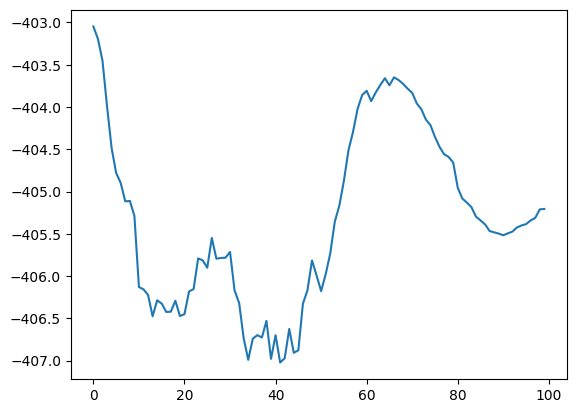

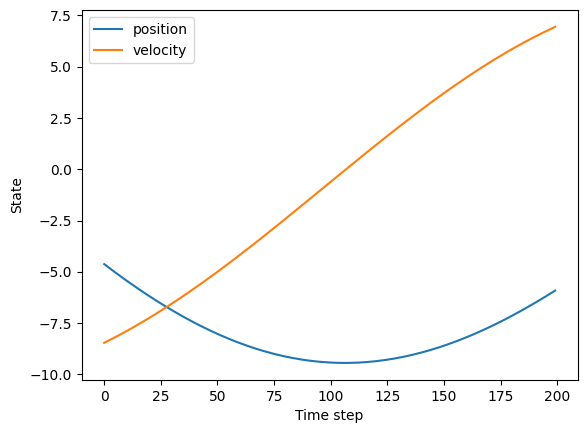

In [3]:

# env = gym.make(ENV_ID).unwrapped

# reproducible
# env.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_range = env.action_space.high  # scale action, [-action_range, action_range]

agent = DDPG(action_dim, state_dim, action_range)
# agent.load()

t0 = time.time()
if True:  # train
    all_episode_reward = []
    for episode in range(TRAIN_EPISODES):
        state = env.reset()
        episode_reward = 0
        for step in range(MAX_STEPS):
            if RENDER:
                env.render()
            # Add exploration noise
            action = agent.get_action(state)
            state_, reward, done, info = env.step(action)
            agent.store_transition(state, action, reward, state_)

            if agent.pointer > MEMORY_CAPACITY:
                agent.learn()

            state = state_
            episode_reward += reward
            if done:
                break

        if episode == 0:
            all_episode_reward.append(episode_reward)
        else:
            all_episode_reward.append(all_episode_reward[-1] * 0.9 + episode_reward * 0.1)
        print(
            'Training  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                episode + 1, TRAIN_EPISODES, episode_reward,
                time.time() - t0
            )
        )
    agent.save()
    plt.plot(all_episode_reward)
    if not os.path.exists('image'):
        os.makedirs('image')
    plt.savefig(os.path.join('image', '_'.join([ALG_NAME, ENV_ID])))

    # plot results
import numpy as np
state_array = np.zeros((MAX_STEPS, 2))
for i in range(MAX_STEPS):
    action = agent.get_action(env.state)
    state, reward, done, info = env.step(action)
    state_array[i] = state
    if done:
        break

plt.figure()
plt.plot(state_array[:, 0], label='position')
plt.plot(state_array[:, 1], label='velocity')
plt.xlabel('Time step')
plt.ylabel('State')
plt.legend()
plt.show()


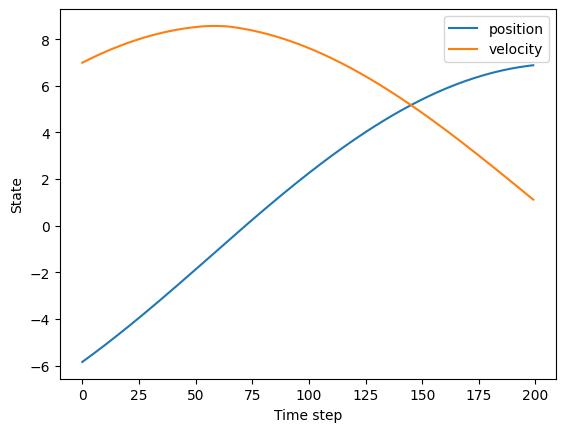

In [4]:
# plot results
import numpy as np
state_array = np.zeros((MAX_STEPS, 2))
for i in range(MAX_STEPS):
    action = agent.get_action(env.state)
    state, reward, done, info = env.step(action)
    state_array[i] = state
    if done:
        break

plt.figure()
plt.plot(state_array[:, 0], label='position')
plt.plot(state_array[:, 1], label='velocity')
plt.xlabel('Time step')
plt.ylabel('State')
plt.legend()
plt.show()

